In [1]:
import pandas as pd
import numpy as np
from plotnine import *

from sklearn.neighbors import KNeighborsClassifier #K-nearest neighbors 
from sklearn.tree import DecisionTreeClassifier # Decision Tree
from sklearn.linear_model import LogisticRegression # Logistic Regression 

from sklearn.preprocessing import StandardScaler #Z-score variables
from sklearn.model_selection import KFold # k-fold cv
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

import warnings
warnings.filterwarnings('ignore')

# HW2

## GENERAL INSTRUCTIONS:

- CLEARLY mark where you are answering each question (all questions must be answered in Markdown cells, NOT as comments in code cells)
- Show all code necessary for the analysis, but remove superfluous code

---

Use the [Loan Dataset](https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/HW2.csv) on GitHub to build the classification models described below.

## Variable Descriptions:
- `age`: age in years of person.
- `had_cancer`: 0 if the person has NOT had cancer or has cancer, 1 if they have.
- `gender_id`: `Male`, `Female`, `Non-Binary`, or `Survey Choices Do Not Accurately Reflect My Identity`.
- `income_in_k`: income in thousands of dollars.
- `state`: state person lives in.
- `credit_score`: credit score.
- `num_credit_sources`: number of sources of credit (includes credit cards, loans, car payments...etc).
- `utilization_rate`: the % of a person's total credit they use on average each month. For example if you have 10,000 dollars in available credit, and use 2,000 your utilization rate would be 0.2 (20%).
- `gave_loan`: whether or not the person got a loan.

## Instructions
1. *Build a KNN, Decision Tree, AND Logistic Regression model to predict whether or not someone got a loan (total of 3 models).*
    - If a variable/predictor has more than 2 categories, use `get_dummies()` to convert them into dummy variables (don't forget to remove the original column when training!).
    - use the KFold() function with 5 folds (use the same KF for-loop to fit all three models, i.e. there should only be one KFold loop where you fit 3 models)
    - Z-score your continuous variables only (interval data like age...etc can be counted as continuous)
    - For KNN, include only *continuous/interval* columns as predictors. For Decision Tree and Logistic Regression use ALL columns (other than `gave_loan`).
    - For KNN, choose K by using grid search.
    - For Decision Trees, use grid search to choose max_depth, and check for overfitting.
    - Record the Train/Test accuracies, and print out confusion matrices.
    
    
2. *Evaluate Your Models (ANSWER IN MARKDOWN CELL)*
    - A) Using accuracy and confusion matrices, **which model did best, how can you tell?**
    - B) **Are there differences in how well the three models you made in part 1 do for different gender IDs? (do not make new models, use the models from before)**
    - C) **Are your models better at predicting people who got loans, or didn't get loans? How can you tell? What are the possible implications of this**

## 1. *Build a KNN, Decision Tree, AND Logistic Regression model to predict whether or not someone got a loan (total of 3 models).*

In [2]:
# Import the data set 
DF = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/HW2.csv")
DF

,age,had_cancer,gender_id,income_in_k,state,credit_score,num_credit_sources,utilization_rate,gave_loan
0,39,0,Female,54,TX,448,4,0.32,0
1,43,0,Female,66,NJ,399,4,0.35,0
2,42,0,Male,50,NE,509,8,0.23,0
3,46,0,Female,79,TX,540,6,0.15,0
4,43,0,Female,49,NV,485,10,0.20,0
...,...,...,...,...,...,...,...,...,...
3995,42,0,Female,59,TX,493,3,0.16,0
3996,44,0,Male,66,AK,659,11,0.36,1
3997,42,0,Male,71,OH,630,3,0.61,1
3998,38,0,Female,62,ID,822,5,0.23,1


In [3]:
# Modify Columns with more than two categories using get_dummies()

# Modify the gender category that has more than one category  
dummies_gender = pd.get_dummies(DF["gender_id"])
# print(dummies_gender)

# Modify the State Category that has more than one category
dummies_state = pd.get_dummies(DF["state"])
# print(dummies_state)

In [4]:
print(dummies_gender.columns)

Index(['Female', 'Male', 'Non-Binary',
       'Survey Choices Do Not Accurately Reflect My Identity'],
      dtype='object')


In [5]:
# Add the new dummies columns and remove the old column that was modified
DF = pd.concat([DF,dummies_gender], axis = 1) #there are other ways to do this too
DF = DF.drop(columns = ["gender_id"])
# DF

In [6]:
print(dummies_state.columns)

Index(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'IA',
       'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO',
       'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK',
       'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI',
       'WV', 'WY'],
      dtype='object')


In [7]:
# Add the new dummies columns and remove the old column that was modified
DF = pd.concat([DF,dummies_state], axis = 1) #there are other ways to do this too
DF = DF.drop(columns = ["state"])
# DF

In [8]:
# Create predictors list 
predictors = ["age", "had_cancer", "income_in_k", "credit_score", "num_credit_sources", "utilization_rate",
             'Female', 'Male', 'Non-Binary', 'Survey Choices Do Not Accurately Reflect My Identity',
             'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'IA','ID', 'IL', 'IN', 'KS', 
              'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
              'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI',
              'WV', 'WY'] #"gender_id", "state"

# Create a sepereate list for the continuous predictors for Z Scoring later
cont_predictors = ["age", "income_in_k", "credit_score", "num_credit_sources", "utilization_rate"]

In [9]:
# Create predictors and outcome variables
X = DF[predictors]
y = DF["gave_loan"]

In [10]:
# Create empty K-Neighbors Model
knn = KNeighborsClassifier()

#Create empty Decision Tree Model
dtree = DecisionTreeClassifier()

# Create empty Logistic Regression model
logr = LogisticRegression()

In [11]:
# Create empty List of Model Names 
names = []

In [12]:
# Create empty lists for Accuracy Score of each model for the TRAINING set 
knn_acc_train = []
dtree_acc_train = []
logr_acc_train = []

# Create list for mean of all accuracy scores for training set
all_model_acc_training = []

# Create empty lists for Accuracy Score of each model for the TESTING set 
knn_acc_test = []
dtree_acc_test = []
logr_acc_test = []

# Create list for mean of all accuracy scores for testing set
all_model_acc_testing = []

In [13]:
# Create K Fold for loop with 5 folds 
kf = KFold(n_splits = 5)

for train, test in kf.split(X):
    X_train = X.iloc[train]
    Xz_train = X.iloc[train]
    X_test = X.iloc[test]
    Xz_test = X.iloc[test]
    y_train = y[train]
    y_test = y[test]
    
    # create Z score object 
    z = StandardScaler()
    z.fit(X_train[cont_predictors])
    Xz_train[cont_predictors] = z.transform(X_train[cont_predictors])
    Xz_test[cont_predictors] = z.transform(X_test[cont_predictors])
    
# Fit the Logistic Regression Model with ALL columns except gave_loan
    logr.fit(X_train, y_train)
    
    # add the accuracy scores of the Decision Tree model to the dtree_acc list for the TRAINING SET
    logr_acc_train.append(accuracy_score(y_train, logr.predict(X_train)))
    
    # add the accuracy scores of the KNN model to the knn_acc list for the TESTING SET
    logr_acc_test.append(accuracy_score(y_test, logr.predict(X_test)))
    

# K-Nearest Neighbors Model 

In [14]:
# Add model name 
names.append("K-Nearest Neighbors")

# Create pipelines for Z Scoring for the KNN model 
zknn = make_column_transformer((StandardScaler(), cont_predictors))

# Make a pipeline object for KNN model 
pipeknn = make_pipeline(zknn, knn)

# print something
# print(pipeknn.get_params().keys())

In [15]:
# Use Grid Search for KNN model
# Create a list of Ks we would like to test
ks = {"kneighborsclassifier__n_neighbors": range(1, 30)}

# Use Grid Search Function to find the best parameter
gridknn = GridSearchCV(pipeknn, ks, scoring = "accuracy", cv = 5, refit = True)

# Create a new knn model with ONLY the continuous predictors 
knnmod = gridknn.fit(X_train[cont_predictors], y_train)

In [16]:
# add the accuracy scores of the KNN model to the knn_acc list for the TRAINING SET
knn_acc_train.append(accuracy_score(y_train, knnmod.predict(X_train[cont_predictors])))
# print(knn_acc_train)
print("Accuracy Score of KNN model on Training set ", accuracy_score(y_train, knnmod.predict(X_train[cont_predictors])))
# np.mean(knn_acc_train)
all_model_acc_training.append(accuracy_score(y_train, knnmod.predict(X_train[cont_predictors])))


# add the accuracy scores of the KNN model to the knn_acc list for the TESTING SET
knn_acc_test.append(accuracy_score(y_test, knnmod.predict(X_test[cont_predictors])))

# print(knn_acc_test)
print("Accuracy Score of KNN model on Testing set ", accuracy_score(y_test, knnmod.predict(X_test[cont_predictors])))
# np.mean(knn_acc_test)
all_model_acc_testing.append(accuracy_score(y_test, knnmod.predict(X_test[cont_predictors])))
# accuracy_score(y_test, knnmod.predict(X_test[cont_predictors]))

# print difference
print("Difference", accuracy_score(y_train, knnmod.predict(X_train[cont_predictors])) - accuracy_score(y_test, knnmod.predict(X_test[cont_predictors])))
# np.mean(knn_acc_train) - np.mean(knn_acc_test)

Accuracy Score of KNN model on Training set  0.74125
Accuracy Score of KNN model on Testing set  0.7175
Difference 0.023749999999999938


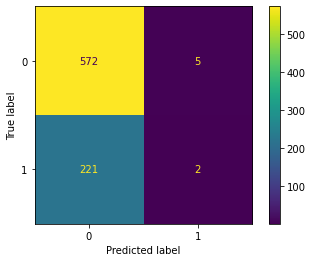

In [17]:
# Plot KNN Confusion Matrix with Testing Set
plot_confusion_matrix(knnmod, X_test[cont_predictors], y_test)

# Decision Tree Model

In [18]:
# Add model name to names list 
names.append("Decision Tree")

# Create pipelines for Z Scoring for the Decision Tree model 
zdtree = make_column_transformer((StandardScaler(), cont_predictors)) 

# Make a pipeline 
pipedtree = make_pipeline(zdtree, dtree)

# Print something
# print(pipedtree.get_params().keys())

In [19]:
# Use Grid Search for the Decision Tree model
# Create a list of max depths we would like to test
maxdepth = {"decisiontreeclassifier__max_depth": range(1, 9)}

# Use Grid Search Function to find the best parameter
griddtree = GridSearchCV(pipedtree, maxdepth, scoring = "accuracy", cv = 5, refit = True)

# Create a new Decision Tree Model with ALL columns except gave_loan
dtreemod = griddtree.fit(X_train, y_train)

print("Best Depth = ", dtreemod.best_estimator_.get_params()["decisiontreeclassifier__max_depth"])

Best Depth =  1


In [20]:
# add the accuracy scores of the Decision Tree model to the dtree_acc list for the TRAINING SET
dtree_acc_train.append(accuracy_score(y_train, dtreemod.predict(X_train)))
# print(dtree_acc_train)
print("Accuracy Score of Decision Tree model on Training set ", accuracy_score(y_train, dtreemod.predict(X_train)))
# np.mean(dtree_acc_train)
all_model_acc_training.append(accuracy_score(y_train, dtreemod.predict(X_train)))

# add the accuracy scores of the KNN model to the knn_acc list for the TESTING SET
dtree_acc_test.append(accuracy_score(y_test, dtreemod.predict(X_test)))
# print(dtree_acc_test)
print("Accuracy Score of Decision Tree model on Testing set ", accuracy_score(y_test, dtreemod.predict(X_test)))
# np.mean(dtree_acc_test)
all_model_acc_testing.append(accuracy_score(y_test, dtreemod.predict(X_test)))

# print difference
print("Difference", accuracy_score(y_train, dtreemod.predict(X_train)) - accuracy_score(y_test, dtreemod.predict(X_test)))
# np.mean(dtree_acc_train) - np.mean(dtree_acc_test)

Accuracy Score of Decision Tree model on Training set  0.73625
Accuracy Score of Decision Tree model on Testing set  0.72125
Difference 0.015000000000000013


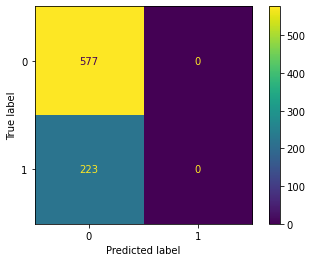

In [21]:
# Plot Decision Tree Confusion Matrix for TESTING set
plot_confusion_matrix(dtreemod, X_test, y_test)

# Logistic Regression Model

In [22]:
# Add model name to names list 
names.append("Logistic Regression")

# add the accuracy scores of the Logistic Regression model to the logr_acc list for the TRAINING SET
logr_acc_train.append(accuracy_score(y_train, logr.predict(X_train)))
# print(logr_acc_train)
print("Accuracy Score of Logistic Regression model on Training set ", accuracy_score(y_train, logr.predict(X_train)))
# np.mean(logr_acc_train)
all_model_acc_training.append(accuracy_score(y_train, logr.predict(X_train)))

# add the accuracy scores of the Logistic Regression model to the logr_acc list for the TESTING SET
logr_acc_test.append(accuracy_score(y_test, logr.predict(X_test)))
# print(logr_acc_test)
print("Accuracy Score of Logistic Regression model on Testing set ", accuracy_score(y_test, logr.predict(X_test)))
# np.mean(logr_acc_test)
all_model_acc_testing.append(accuracy_score(y_test, logr.predict(X_test)))


# print difference
print("Difference", accuracy_score(y_train, logr.predict(X_train)) - accuracy_score(y_test, logr.predict(X_test)))
# np.mean(logr_acc_train) - np.mean(logr_acc_test)

Accuracy Score of Logistic Regression model on Training set  0.73875
Accuracy Score of Logistic Regression model on Testing set  0.715
Difference 0.02375000000000005


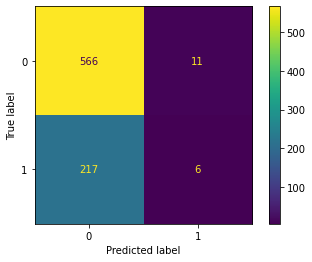

In [23]:
# Plot Logistic Regression Confusion Matrix for TESTING set
plot_confusion_matrix(logr, X_test, y_test)

In [24]:
# Accuracy Score chart for all models
acc_DF_testing = pd.DataFrame({ "Model Name": names,
                       "Accuracy Score": all_model_acc_testing })
acc_DF_testing

,Model Name,Accuracy Score
0,K-Nearest Neighbors,0.71750
1,Decision Tree,0.72125
2,Logistic Regression,0.71500


## 2. *Evaluate Your Models (ANSWER IN MARKDOWN CELL)*

A) Using accuracy and confusion matrices, **which model did best, how can you tell?**
    

The model that preformed the best was the Decision Tree Model. If we take a look at the accuracy scores for the Testing set, in the chart above, we see that the accuracy score for the Decision Tree model is the largest of the three models. Although the Decision Tree model has the highest accuracy score, when looking at the confusion matrix for the Decision Tree Model we see that the model has some concerning issues, the main issue that concerns me is that the two entries in the right column are both zero. This means that my Decision Tree Model is not predicting that person ***would*** recieve a loan at all. However, the other two models appear to have a similar trend with low values close to zero in the right column. For this reason we must pay extra attention to the accuracy scores of the three models, because the confusion matrices are all relatively the same and do not necessarily help in distinguishing which model is the best. 

B) **Are there differences in how well the three models you made in part 1 do for different gender IDs? (do not make new models, use the models from before)**
   

#### Accuracy Score of the three Models Based on Gender ID = Female ONLY

In [25]:
# 'Female' ONLY
female = DF['Female'] == 1
print("Accuracy Score of KNN", accuracy_score(y_test.loc[female], knnmod.predict(X_test[cont_predictors].loc[female])))
print("Accuracy Score of Decision Tree", accuracy_score(y_test.loc[female], dtreemod.predict(X_test.loc[female])))
print("Accuracy Score of Logistic Regression", accuracy_score(y_test.loc[female], logr.predict(X_test.loc[female])))

Accuracy Score of KNN 0.7358024691358025
Accuracy Score of Decision Tree 0.7407407407407407
Accuracy Score of Logistic Regression 0.7308641975308642


#### Accuracy Score of the three Models Based on Gender ID = Male ONLY

In [26]:
# 'Male' ONLY
male = DF['Male'] == 1
print("Accuracy Score of KNN", accuracy_score(y_test.loc[male], knnmod.predict(X_test[cont_predictors].loc[male])))
print("Accuracy Score of Decision Tree", accuracy_score(y_test.loc[male], dtreemod.predict(X_test.loc[male])))
print("Accuracy Score of Logistic Regression", accuracy_score(y_test.loc[male], logr.predict(X_test.loc[male])))

Accuracy Score of KNN 0.6957671957671958
Accuracy Score of Decision Tree 0.6957671957671958
Accuracy Score of Logistic Regression 0.6931216931216931


#### Accuracy Score of the three Models Based on Gender ID = Non-Binary ONLY

In [27]:
# 'Non-Binary' ONLY
nb = DF['Non-Binary'] == 1
print("Accuracy Score of KNN", accuracy_score(y_test.loc[nb], knnmod.predict(X_test[cont_predictors].loc[nb])))
print("Accuracy Score of Decision Tree", accuracy_score(y_test.loc[nb], dtreemod.predict(X_test.loc[nb])))
print("Accuracy Score of Logistic Regression", accuracy_score(y_test.loc[nb], logr.predict(X_test.loc[nb])))

Accuracy Score of KNN 0.8
Accuracy Score of Decision Tree 0.8
Accuracy Score of Logistic Regression 0.8


#### Accuracy Score of the three Models Based on Gender ID = Survey Choices Do Not Accurately Reflect My Identity ONLY

In [28]:
# 'Survey Choices Do Not Accurately Reflect My Identity' ONLY
sc = DF['Survey Choices Do Not Accurately Reflect My Identity'] == 1
print("Accuracy Score of KNN", accuracy_score(y_test.loc[sc], knnmod.predict(X_test[cont_predictors].loc[sc])))
print("Accuracy Score of Decision Tree", accuracy_score(y_test.loc[sc], dtreemod.predict(X_test.loc[sc])))
print("Accuracy Score of Logistic Regression", accuracy_score(y_test.loc[sc], logr.predict(X_test.loc[sc])))

Accuracy Score of KNN 0.7142857142857143
Accuracy Score of Decision Tree 0.8571428571428571
Accuracy Score of Logistic Regression 0.8571428571428571


## Comments on Accuracy Scores Over Different Gender IDs

From the results above, I can see that for each individual Gender ID all three models have accuracy scores that are fairly close to one another. Their relatively similarilarity in accuracy scores is a good result to see because it means that my models are not bias regarding Gender ID.

However, overall the models appear to have varied accuracy scores for different Gender IDs which is slightly concerning but the difference is not so large that I believe the result negatively effects the overall accuracies of all of my models.

C) **Are your models better at predicting people who got loans, or didn't get loans? How can you tell? What are the possible implications of this**

All of my models are better at predicting people who **do not** get loans. From the confusion matricies of all three of my models, we can see that the upper left corner of each confusion matrix has the highest values of the matrix. What this means is that each of my models are very accurate at predicting True negatives, or in other words when my models predicted that a person would not recieve a loan the data confirmed this prediction. 

A possible implication about why my models are  better at predicting True Negatives, may be the result of the data I used to build and test my models. If the data were from a very concervative bank or credit entity this may explain why my models are better at predicting people who **do not** get a loan, rather than the alternative.

One possible ethical implication of this result is that if my models are used to predict who *should* recieve a loan they may deny people who do deserve to get a loan from recieving loans. While I think this is a valid concern given that all of my models have accuracies in the 0.7's I think it is better to error on the side of caution. What I mean is, that I believe it is better to predict that some people should not recieve a loan and deny people who deserve to recieve a loan than to predict that a person should recieve a loan and then give loans to people who do not deserve to recieve a loan. The reason I think this is a better outcome is because the possible risks associated with giving loans to people who do not deserve them, such as those people defaulting on the loan, causes more systemic damage to a community than not giving loans to people who deserve them. 
